In [2]:
%matplotlib inline
from subprocess import run
import os
from matplotlib import patches, collections
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from cartopy import crs, feature
import xarray as xr
import numpy as np

In [2]:
# Target resolution grids for E3SMv2
# We'll use the already produced grid files for v1
grid_dir = '/mnt/d/Work/Codes/grid_dir'
os.makedirs(grid_dir, exist_ok=True)
res_list = [4, 16, 30, 120]
for res in res_list:
    run(f'GenerateVolumetricMesh --in {grid_dir}/ne{res}.g --out {grid_dir}/ne{res}pg2.g --np 2 --uniform'.split(' '), capture_output=True)
# Adding the RRM northamerica grid file from e3sm input
run(f'GenerateVolumetricMesh --in {grid_dir}/northamericax4v1.g --out {grid_dir}/northamericax4v1pg2.g --np 2 --uniform'.split(' '), capture_output=True)

CompletedProcess(args=['GenerateVolumetricMesh', '--in', '/mnt/d/Work/Codes/grid_dir/northamericax4v1.g', '--out', '/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2.g', '--np', '2', '--uniform'], returncode=0, stdout=b'Parameters:\n  --in <string> ["/mnt/d/Work/Codes/grid_dir/northamericax4v1.g"] \n  --out <string> ["/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2.g"] \n  --np <integer> [2] \n  --uniform <bool> [true] \n------------------------------------------------------------\n\n..Loading input mesh\nMesh size: Nodes [14456] Elements [14454]\n..Computing sub-volume boundaries\n..Generating sub-volumes\n..Writing mesh\nNodes per element\n..Block 1 (4 nodes): 57816\n..Mesh generator exited successfully\n=========================================================\n', stderr=b'')

In [3]:
# Open the grid files as xarray
ne4pg2 = xr.open_dataset(grid_dir+'/ne4pg2.g')
ne16pg2 = xr.open_dataset(grid_dir+'/ne16pg2.g')
ne30pg2 = xr.open_dataset(grid_dir+'/ne30pg2.g')
ne120pg2 = xr.open_dataset(grid_dir+'/ne120pg2.g')
NApg2 = xr.open_dataset(grid_dir+'/northamericax4v1pg2.g')

In [4]:
# Func to plot the exodus files
def get_lines(ds,ax):
    x = ds['coord'][0,:].squeeze()
    y = ds['coord'][1,:].squeeze()
    z = ds['coord'][2,:].squeeze()
    lon = np.arctan2(y, x) * 180.0 / np.pi
    lat = np.arcsin(z) * 180.0 / np.pi
    corner_indices = ds['connect1']
    xx = lon[corner_indices[:,:] - 1]
    yy = lat[corner_indices[:,:] - 1]
    lines = [[[xx[i,j], yy[i,j]] for j in range(xx.shape[1])] for i in range(xx.shape[0])]
    line_collection = collections.LineCollection(lines, transform=crs.Geodetic(),colors='k',linewidth=0.1)
    ax.add_collection(line_collection)

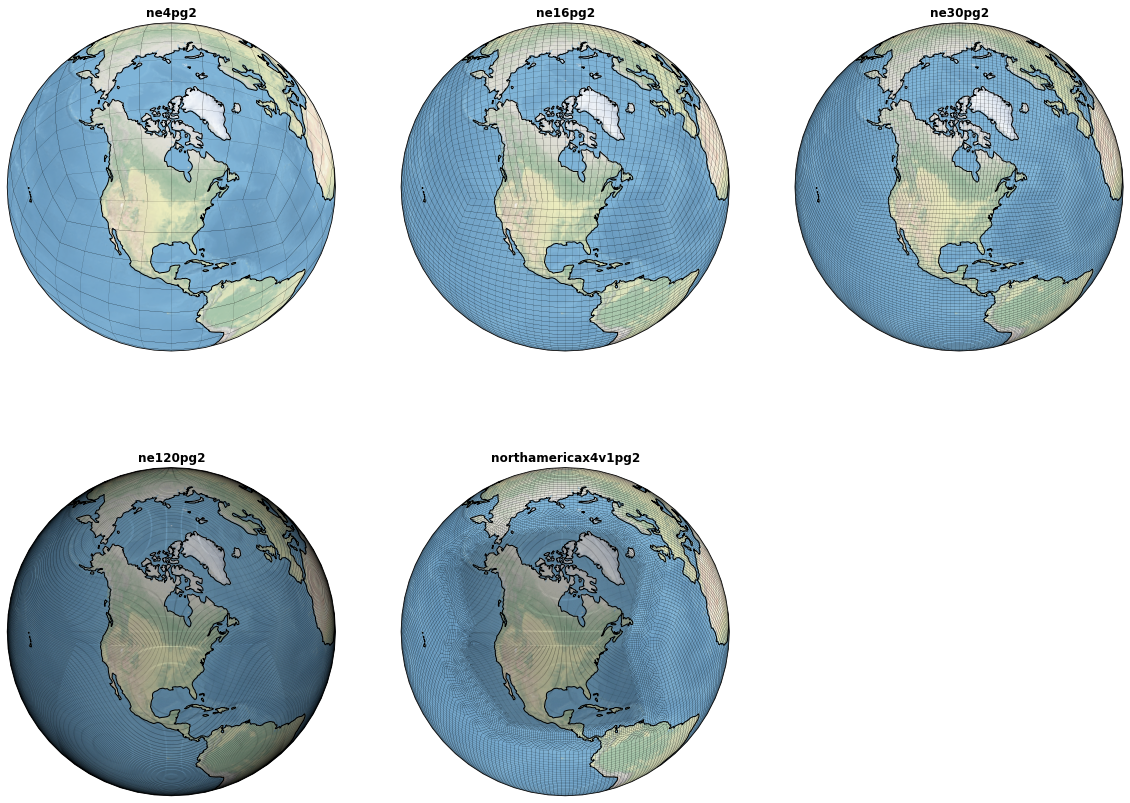

In [5]:
# Compare grids
figure = plt.figure(figsize=(20, 15))
i=1
for grid,t in zip([ne4pg2, ne16pg2, ne30pg2, ne120pg2, NApg2],['ne4pg2', 'ne16pg2', 'ne30pg2', 'ne120pg2', 'northamericax4v1pg2']):
    ax = figure.add_subplot(230+i, projection=crs.Orthographic(central_latitude=50,central_longitude=-90))
    ax.stock_img()
    ax.coastlines()
    lines=get_lines(grid,ax)
    ax.set_title(t, weight='bold',fontsize=12)
    i=i+1

In [7]:
# Produce scrip files for each grid type
# These can be used to make the map files
for res in res_list:
    run(f'ConvertExodusToSCRIP --in {grid_dir}/ne{res}pg2.g --out {grid_dir}/ne{res}pg2_scrip.nc'.split(' '), capture_output=True)
run(f'ConvertExodusToSCRIP --in {grid_dir}/northamericax4v1pg2.g --out {grid_dir}/northamericax4v1pg2_scrip.nc'.split(' '), capture_output=True)

CompletedProcess(args=['ConvertExodusToSCRIP', '--in', '/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2.g', '--out', '/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2_scrip.nc'], returncode=0, stdout=b'Parameters:\n  --in <string> ["/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2.g"] \n  --out <string> ["/mnt/d/Work/Codes/grid_dir/northamericax4v1pg2_scrip.nc"] \n  --out_format <string> ["netcdf4"] \n------------------------------------------------------------\n\n..Loading input mesh\nMesh size: Nodes [57818] Elements [57816]\n..Writing mesh\nNodes per element\n..Block 1 (4 nodes): 57816\n..Done writing\n..Mesh converter exited successfully\n=========================================================\n', stderr=b'')

In [7]:
# Checking out the grid size for each grids in the scrip files
for res in res_list:
    print('Grid size of ne'+str(res)+'pg2', xr.open_dataset(grid_dir+'/ne'+str(res)+'pg2_scrip.nc').dims['grid_size'])
print('Grid size of northamericax4v1pg2', xr.open_dataset(grid_dir+'/northamericax4v1pg2_scrip.nc').dims['grid_size'])

Grid size of ne4pg2 384
Grid size of ne16pg2 6144
Grid size of ne30pg2 21600
Grid size of ne120pg2 345600
Grid size of northamericax4v1pg2 57816
